# 7. LSTM + DNN (News Data)

### Q. 왜 LSTM을 썼는가?

### A.
- LSTM은 시간에 따라 수집된 이전 데이터 포인트를 기반으로 미래 값을 예측하는, 시계열 문제를 잘 푸는 모델
- 본 코드에 데이터를 주식데이터와 Finbert 결과를 넣을때, 그 인접한 시간대 3타임 전 주가데이터를 넣고 학습함
- 그러기에, 전통적인 주가 예측 방법에서 사용되는 LSTM을 사용하는 것을 선택함

### Q. 왜 MLP (6. LSTM + ""DNN""이라고 표시한것) 을 사용하였는가?

### A.
- 현재 프로젝트는 기본적인 LSTM 만으로 주가데이터를 예측하지 않음
- 따라서, MLP를 사용해서 Finbert 의 Tabular 데이터를 처리함
- Finbert의 결과는 시계열과 상관이 없기에, 이런 방식을 채택함

### Q. Tweets과 News Data 버전을 분리한 이유 + 트윗이랑 뉴스랑 나눠서 어떤걸 보여주는가?

### A.
- Tweet 데이터를 넣었을때 값이 얼마나 바뀌는지가 중요했음
- 그러나 Tweets 데이터를 넣었을때 중립 혹은 긍정 값이 너무 많았음 (X에서 Ceo와 유명 주식투자자들은 보통 긍정적인 게시글만 올림)
- 결론적으로 값이 잘 반영되지 않아, 오히려 Accuracy 가 낮게 나오는 경향이 있어서, 모델을 나누었음
- 뉴스는 대체적으로 예측에 긍정적인 결과 부분이 있고, 트윗으로 했을때는 결과가 좋지 않았음

### Q. 본 프로젝트는 데이터가 편향(현재 데이터에 중립값이 너무 많아 모델이 중립값으로 무조건적으로 찍기만 하는 현상)을 줄이기위해 어떤 노력을 했는가?
### A.
- 일차적으로, SMOTE(데이터 오버 샘플링 기법)으로 0.4%오르거나 0.4% 내린 데이터들이 너무 적기에 그 데이터들을 합성함. 하지만, 애초에 데이터셋 자체가 너무 시계열에 너무 어렵고 합성한다 해도 오히려 모델에 방해가 되었음.
- 그래서 Finbert의 중요도가 더욱 중요하다고 생각했고, 결론적으로 LSTM + MLP 모델에서 Finbert의 피쳐 중요도를 높임.

### Q. 왜 0.4% 기준으로 나눴는가?
### A.
- %비율을 낮추면, 기본적으로 주식 데이터에서 발생하는 약간의 의미없는 오르내림을 포함함, 이 원인으로 Noise를 예측하게 되고 결과에 부정적인 역할을 끼침
- %비율을 높인다면, 샘플수가 너무 적게되어 의미가 없어짐
- 따라서 0.4의 기준은 여러 실험을 통하여 적절한 샘플의 값과 적절한 Noise제거 효과를 지니는 값을 선정함함

### Q. Target 값을 어떻게 정의하였는가?
### A.
- News만 사용했던 모델에서는 (8시 3분 뉴스) 라고 한다면 7시 6시 5시 데이터의 주가 지표(이동평균선,,,,) + Finbert (긍, 중립, 부정) 값을 결합함
- 이후 데이터를 정의하였고, 최종적으로 Target은 "9시에 어떻게 변화했는가? (returns)"를 지정함

## 6-1 데이터 전처리  
- 주식 데이터와 뉴스 데이터를 합쳐서 저장하는 코드
- Target 값 정의, 뉴스 시간 이전의 3개 데이터 값 저장
- Target은 등략률 0.4이상 : 2 0.4미만 -0.4초과 : 1 -0.4이하 0

In [1]:
import pandas as pd

stock_path = "../data/AAPL_1hour_data_365days.csv"
news_path = "../data/apple_finbert_finnhub.csv"

stock_df = pd.read_csv(stock_path, parse_dates=["Datetime"])
news_df = pd.read_csv(news_path, parse_dates=["pubDate"])

stock_df["Datetime"] = stock_df["Datetime"].dt.tz_localize(None)
news_df["pubDate"] = news_df["pubDate"].dt.tz_localize(None)
stock_df = stock_df.sort_values("Datetime").reset_index(drop=True)
stock_df = stock_df.drop(columns=[col for col in ['Is_Trading_Hours', 'Is_Market_Open', 'Is_Premarket', 'Is_Aftermarket', 'Is_Extended_Hours'] if col in stock_df.columns])

rows = []
for _, news_row in news_df.iterrows():
    news_time = news_row['pubDate']
    future_stock = stock_df[stock_df['Datetime'] > news_time].head(1)
    if future_stock.empty:
        continue

    target_row = future_stock.iloc[0]
    target_time = target_row['Datetime']
    target_close = target_row['Close']

    past_rows = stock_df[stock_df['Datetime'] < target_time].tail(3)
    if len(past_rows) < 3:
        continue

    past_last_close = past_rows.iloc[-1]['Close']
    return_pct = (target_close - past_last_close) / past_last_close * 100
    label = 1 if return_pct >= 0.4 else (-1 if return_pct <= -0.4 else 0)

    row = {
        "news_id": news_row['id'],
        "news_time": news_time,
        "target_close": target_close,
        "target_return_pct": return_pct,
        "target_multi_raw": label,
        "finbert_positive": news_row['finbert_positive'],
        "finbert_neutral": news_row['finbert_neutral'],
        "finbert_negative": news_row['finbert_negative'],
    }

    for i, (_, stock_row) in enumerate(past_rows.iterrows(), 1):
        for col in stock_df.columns:
            if col != "Datetime":
                row[f"x{i}_{col}"] = stock_row[col]

    rows.append(row)

merged_df = pd.DataFrame(rows)
merged_df["target_multi"] = merged_df["target_multi_raw"].map({-1: 0, 0: 1, 1: 2})
merged_df.to_csv("../data/news_stock_classification.csv", index=False)
print("병합 완료: news_stock_classification.csv 저장됨")

병합 완료: news_stock_classification.csv 저장됨


## 6-2 LSTM + MLP 학습코드  
- LSTM 에 시계열(과거 3개의 데이터) + Finbert DNN 학습 후 concat => 3진분류

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# 1. 데이터 불러오기 및 전처리
df = pd.read_csv("../data/news_stock_classification.csv", parse_dates=["news_time"])
feature_cols = [col for col in df.columns if col.startswith("x") or col.startswith("finbert_")]
X = df[feature_cols].fillna(0)
y = df["target_multi"]

# 2. 시계열 주가 입력 생성 (x1_, x2_, x3_ 시점)
X_seq = []
for i in range(len(X)):
    X_seq.append([
        X.iloc[i][[col for col in X.columns if col.startswith("x1_")]].values,
        X.iloc[i][[col for col in X.columns if col.startswith("x2_")]].values,
        X.iloc[i][[col for col in X.columns if col.startswith("x3_")]].values
    ])
X_seq = np.array(X_seq)  # (샘플, 3, 피처수)

# 3. FinBERT 감정 점수는 별도 분리
X_emo = X[[col for col in X.columns if col.startswith("finbert_")]].values

# 4. 정규화
scaler_seq = StandardScaler()
X_seq_scaled = scaler_seq.fit_transform(X_seq.reshape(-1, X_seq.shape[-1])).reshape(X_seq.shape)

scaler_emo = StandardScaler()
X_emo_scaled = scaler_emo.fit_transform(X_emo)

# 5. Tensor 변환
X_seq_tensor = torch.tensor(X_seq_scaled, dtype=torch.float32)
X_emo_tensor = torch.tensor(X_emo_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

# 6. 훈련/테스트 분할
X_seq_train, X_seq_test, X_emo_train, X_emo_test, y_train, y_test = train_test_split(
    X_seq_tensor, X_emo_tensor, y_tensor, test_size=0.2, shuffle=False
)

train_dl = DataLoader(TensorDataset(X_seq_train, X_emo_train, y_train), batch_size=32, shuffle=True)
test_dl = DataLoader(TensorDataset(X_seq_test, X_emo_test, y_test), batch_size=32, shuffle=False)

# 7. 모델 정의 (LSTM + DNN)
class LSTM_DNN_Classifier(nn.Module):
    def __init__(self, seq_input_dim, emo_input_dim, hidden_dim=64, lstm_layers=2,
                 dnn_hidden=[64, 32], output_dim=3):
        super().__init__()
        self.lstm = nn.LSTM(seq_input_dim, hidden_dim, num_layers=lstm_layers,
                            batch_first=True, dropout=0.3 if lstm_layers > 1 else 0)
        
        dnn_layers = []
        in_dim = emo_input_dim
        for hidden in dnn_hidden:
            dnn_layers.append(nn.Linear(in_dim, hidden))
            dnn_layers.append(nn.ReLU())
            dnn_layers.append(nn.Dropout(0.3))
            in_dim = hidden
        self.emo_dnn = nn.Sequential(*dnn_layers)

        self.classifier = nn.Linear(hidden_dim + dnn_hidden[-1], output_dim)

    def forward(self, seq_x, emo_x):
        _, (hn, _) = self.lstm(seq_x)
        lstm_out = hn[-1]
        emo_out = self.emo_dnn(emo_x)
        x = torch.cat([lstm_out, emo_out*20.0], dim=1)
        return self.classifier(x)


# 8. 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM_DNN_Classifier(seq_input_dim=X_seq.shape[2], emo_input_dim=X_emo.shape[1]).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 9. 학습 루프
for epoch in range(50):
    model.train()
    total_loss = 0
    for seq_x, emo_x, yb in train_dl:
        seq_x, emo_x, yb = seq_x.to(device), emo_x.to(device), yb.to(device)
        pred = model(seq_x, emo_x)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1:02d} | Loss: {total_loss:.4f}")

# 10. 평가
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for seq_x, emo_x, yb in test_dl:
        seq_x, emo_x = seq_x.to(device), emo_x.to(device)
        logits = model(seq_x, emo_x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(yb.numpy())


Epoch 01 | Loss: 188.1716
Epoch 02 | Loss: 140.5702
Epoch 03 | Loss: 125.3258
Epoch 04 | Loss: 113.7090
Epoch 05 | Loss: 103.8273
Epoch 06 | Loss: 97.7820
Epoch 07 | Loss: 89.6141
Epoch 08 | Loss: 84.1732
Epoch 09 | Loss: 80.1013
Epoch 10 | Loss: 76.4557
Epoch 11 | Loss: 71.1227
Epoch 12 | Loss: 68.8652
Epoch 13 | Loss: 63.8356
Epoch 14 | Loss: 60.9206
Epoch 15 | Loss: 58.8443
Epoch 16 | Loss: 55.2935
Epoch 17 | Loss: 52.5773
Epoch 18 | Loss: 49.5452
Epoch 19 | Loss: 46.9227
Epoch 20 | Loss: 43.9458
Epoch 21 | Loss: 43.5279
Epoch 22 | Loss: 40.5937
Epoch 23 | Loss: 37.0408
Epoch 24 | Loss: 36.5861
Epoch 25 | Loss: 34.2339
Epoch 26 | Loss: 34.7934
Epoch 27 | Loss: 31.9505
Epoch 28 | Loss: 29.8179
Epoch 29 | Loss: 30.1381
Epoch 30 | Loss: 28.0848
Epoch 31 | Loss: 26.8529
Epoch 32 | Loss: 26.2184
Epoch 33 | Loss: 24.4691
Epoch 34 | Loss: 23.6398
Epoch 35 | Loss: 21.8307
Epoch 36 | Loss: 20.7481
Epoch 37 | Loss: 21.8265
Epoch 38 | Loss: 19.2221
Epoch 39 | Loss: 18.5576
Epoch 40 | Loss: 16.

In [3]:
print("\n[평가 결과]")
print(classification_report(all_targets, all_preds, digits=4))
print(f"Accuracy: {accuracy_score(all_targets, all_preds):.4f}")



[평가 결과]
              precision    recall  f1-score   support

           0     0.1694    0.1667    0.1680       246
           1     0.7337    0.8080    0.7691      1224
           2     0.0945    0.0486    0.0642       247

    accuracy                         0.6069      1717
   macro avg     0.3325    0.3411    0.3338      1717
weighted avg     0.5609    0.6069    0.5815      1717

Accuracy: 0.6069


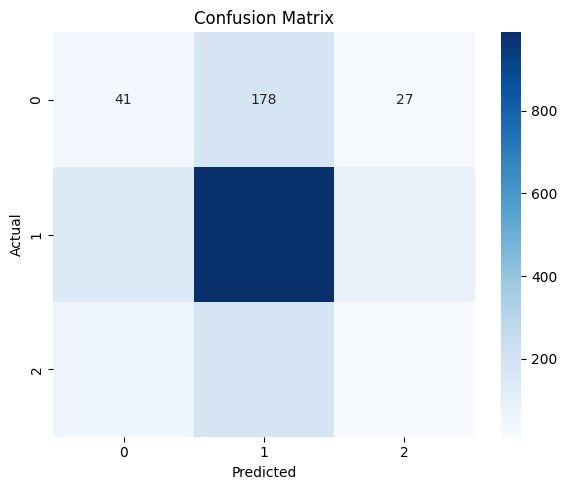

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 혼동 행렬 계산
cm = confusion_matrix(all_targets, all_preds)

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


## LSTM + DNN (no Finbert)
- finbert가 없는 버전  
- 일반화 성능이 많이 떨어지고 있는 모습을 보여줌
- 특히 하락을 거의 예측하지 못함

In [5]:
# 1. 감정 점수 없이 feature 구성
X_no_emo = df[[col for col in df.columns if col.startswith("x")]].fillna(0)

# 2. 시계열 구성 동일하게
X_seq_noemo = []
for i in range(len(X_no_emo)):
    X_seq_noemo.append([
        X_no_emo.iloc[i][[col for col in X_no_emo.columns if col.startswith("x1_")]].values,
        X_no_emo.iloc[i][[col for col in X_no_emo.columns if col.startswith("x2_")]].values,
        X_no_emo.iloc[i][[col for col in X_no_emo.columns if col.startswith("x3_")]].values
    ])
X_seq_noemo = np.array(X_seq_noemo)

# 3. 정규화
scaler_noemo = StandardScaler()
X_seq_noemo_scaled = scaler_noemo.fit_transform(X_seq_noemo.reshape(-1, X_seq_noemo.shape[-1])).reshape(X_seq_noemo.shape)

# 4. 텐서 변환
X_seq_noemo_tensor = torch.tensor(X_seq_noemo_scaled, dtype=torch.float32)
y_tensor_noemo = torch.tensor(y.values, dtype=torch.long)

# 5. Train/Test 분할
X_seq_train_n, X_seq_test_n, y_train_n, y_test_n = train_test_split(
    X_seq_noemo_tensor, y_tensor_noemo, test_size=0.2, shuffle=False
)

train_dl_n = DataLoader(TensorDataset(X_seq_train_n, y_train_n), batch_size=32, shuffle=True)
test_dl_n = DataLoader(TensorDataset(X_seq_test_n, y_test_n), batch_size=32, shuffle=False)

# 6. 모델 정의 (LSTM only)
class LSTM_Only_Classifier(nn.Module):
    def __init__(self, seq_input_dim, hidden_dim=64, lstm_layers=2, output_dim=3):
        super().__init__()
        self.lstm = nn.LSTM(seq_input_dim, hidden_dim, num_layers=lstm_layers,
                            batch_first=True, dropout=0.3 if lstm_layers > 1 else 0)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, seq_x):
        _, (hn, _) = self.lstm(seq_x)
        lstm_out = hn[-1]
        return self.classifier(lstm_out)

# 7. 학습
model_n = LSTM_Only_Classifier(seq_input_dim=X_seq_noemo.shape[2]).to(device)
loss_fn_n = nn.CrossEntropyLoss()
optimizer_n = torch.optim.Adam(model_n.parameters(), lr=1e-3)

for epoch in range(50):
    model_n.train()
    total_loss = 0
    for seq_x, yb in train_dl_n:
        seq_x, yb = seq_x.to(device), yb.to(device)
        pred = model_n(seq_x)
        loss = loss_fn_n(pred, yb)

        optimizer_n.zero_grad()
        loss.backward()
        optimizer_n.step()
        total_loss += loss.item()
    print(f"[NoFinBERT] Epoch {epoch+1:02d} | Loss: {total_loss:.4f}")


[NoFinBERT] Epoch 01 | Loss: 166.6451
[NoFinBERT] Epoch 02 | Loss: 142.0739
[NoFinBERT] Epoch 03 | Loss: 127.0987
[NoFinBERT] Epoch 04 | Loss: 114.9054
[NoFinBERT] Epoch 05 | Loss: 106.3545
[NoFinBERT] Epoch 06 | Loss: 98.3106
[NoFinBERT] Epoch 07 | Loss: 89.5321
[NoFinBERT] Epoch 08 | Loss: 84.5010
[NoFinBERT] Epoch 09 | Loss: 79.9890
[NoFinBERT] Epoch 10 | Loss: 73.2256
[NoFinBERT] Epoch 11 | Loss: 70.2398
[NoFinBERT] Epoch 12 | Loss: 65.2953
[NoFinBERT] Epoch 13 | Loss: 61.8785
[NoFinBERT] Epoch 14 | Loss: 58.0902
[NoFinBERT] Epoch 15 | Loss: 56.2524
[NoFinBERT] Epoch 16 | Loss: 55.3762
[NoFinBERT] Epoch 17 | Loss: 51.5383
[NoFinBERT] Epoch 18 | Loss: 49.4069
[NoFinBERT] Epoch 19 | Loss: 45.8784
[NoFinBERT] Epoch 20 | Loss: 43.8138
[NoFinBERT] Epoch 21 | Loss: 42.6631
[NoFinBERT] Epoch 22 | Loss: 41.2360
[NoFinBERT] Epoch 23 | Loss: 39.2145
[NoFinBERT] Epoch 24 | Loss: 38.0620
[NoFinBERT] Epoch 25 | Loss: 35.8208
[NoFinBERT] Epoch 26 | Loss: 33.5148
[NoFinBERT] Epoch 27 | Loss: 31.3

In [6]:
# 10. 평가
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for seq_x, emo_x, yb in test_dl:
        seq_x, emo_x = seq_x.to(device), emo_x.to(device)
        output = model(seq_x, emo_x)
        pred = torch.argmax(output, dim=1)

        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(yb.numpy())

# 11. 출력
print("\n[평가 결과]")
print(classification_report(all_targets, all_preds, digits=4))
print(f"Accuracy: {accuracy_score(all_targets, all_preds):.4f}")


[평가 결과]
              precision    recall  f1-score   support

           0     0.1694    0.1667    0.1680       246
           1     0.7337    0.8080    0.7691      1224
           2     0.0945    0.0486    0.0642       247

    accuracy                         0.6069      1717
   macro avg     0.3325    0.3411    0.3338      1717
weighted avg     0.5609    0.6069    0.5815      1717

Accuracy: 0.6069


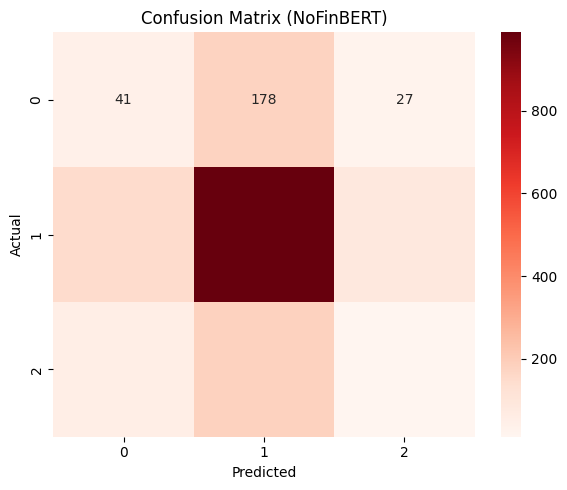

In [7]:
cm_n = confusion_matrix(all_targets, all_preds)

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm_n, annot=True, fmt='d', cmap='Reds', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (NoFinBERT)")
plt.tight_layout()
plt.show()

# 8. LSTM + DNN (Tweets Data)

분석할 수치형 변수 개수: 100
데이터 크기: (5517, 102)


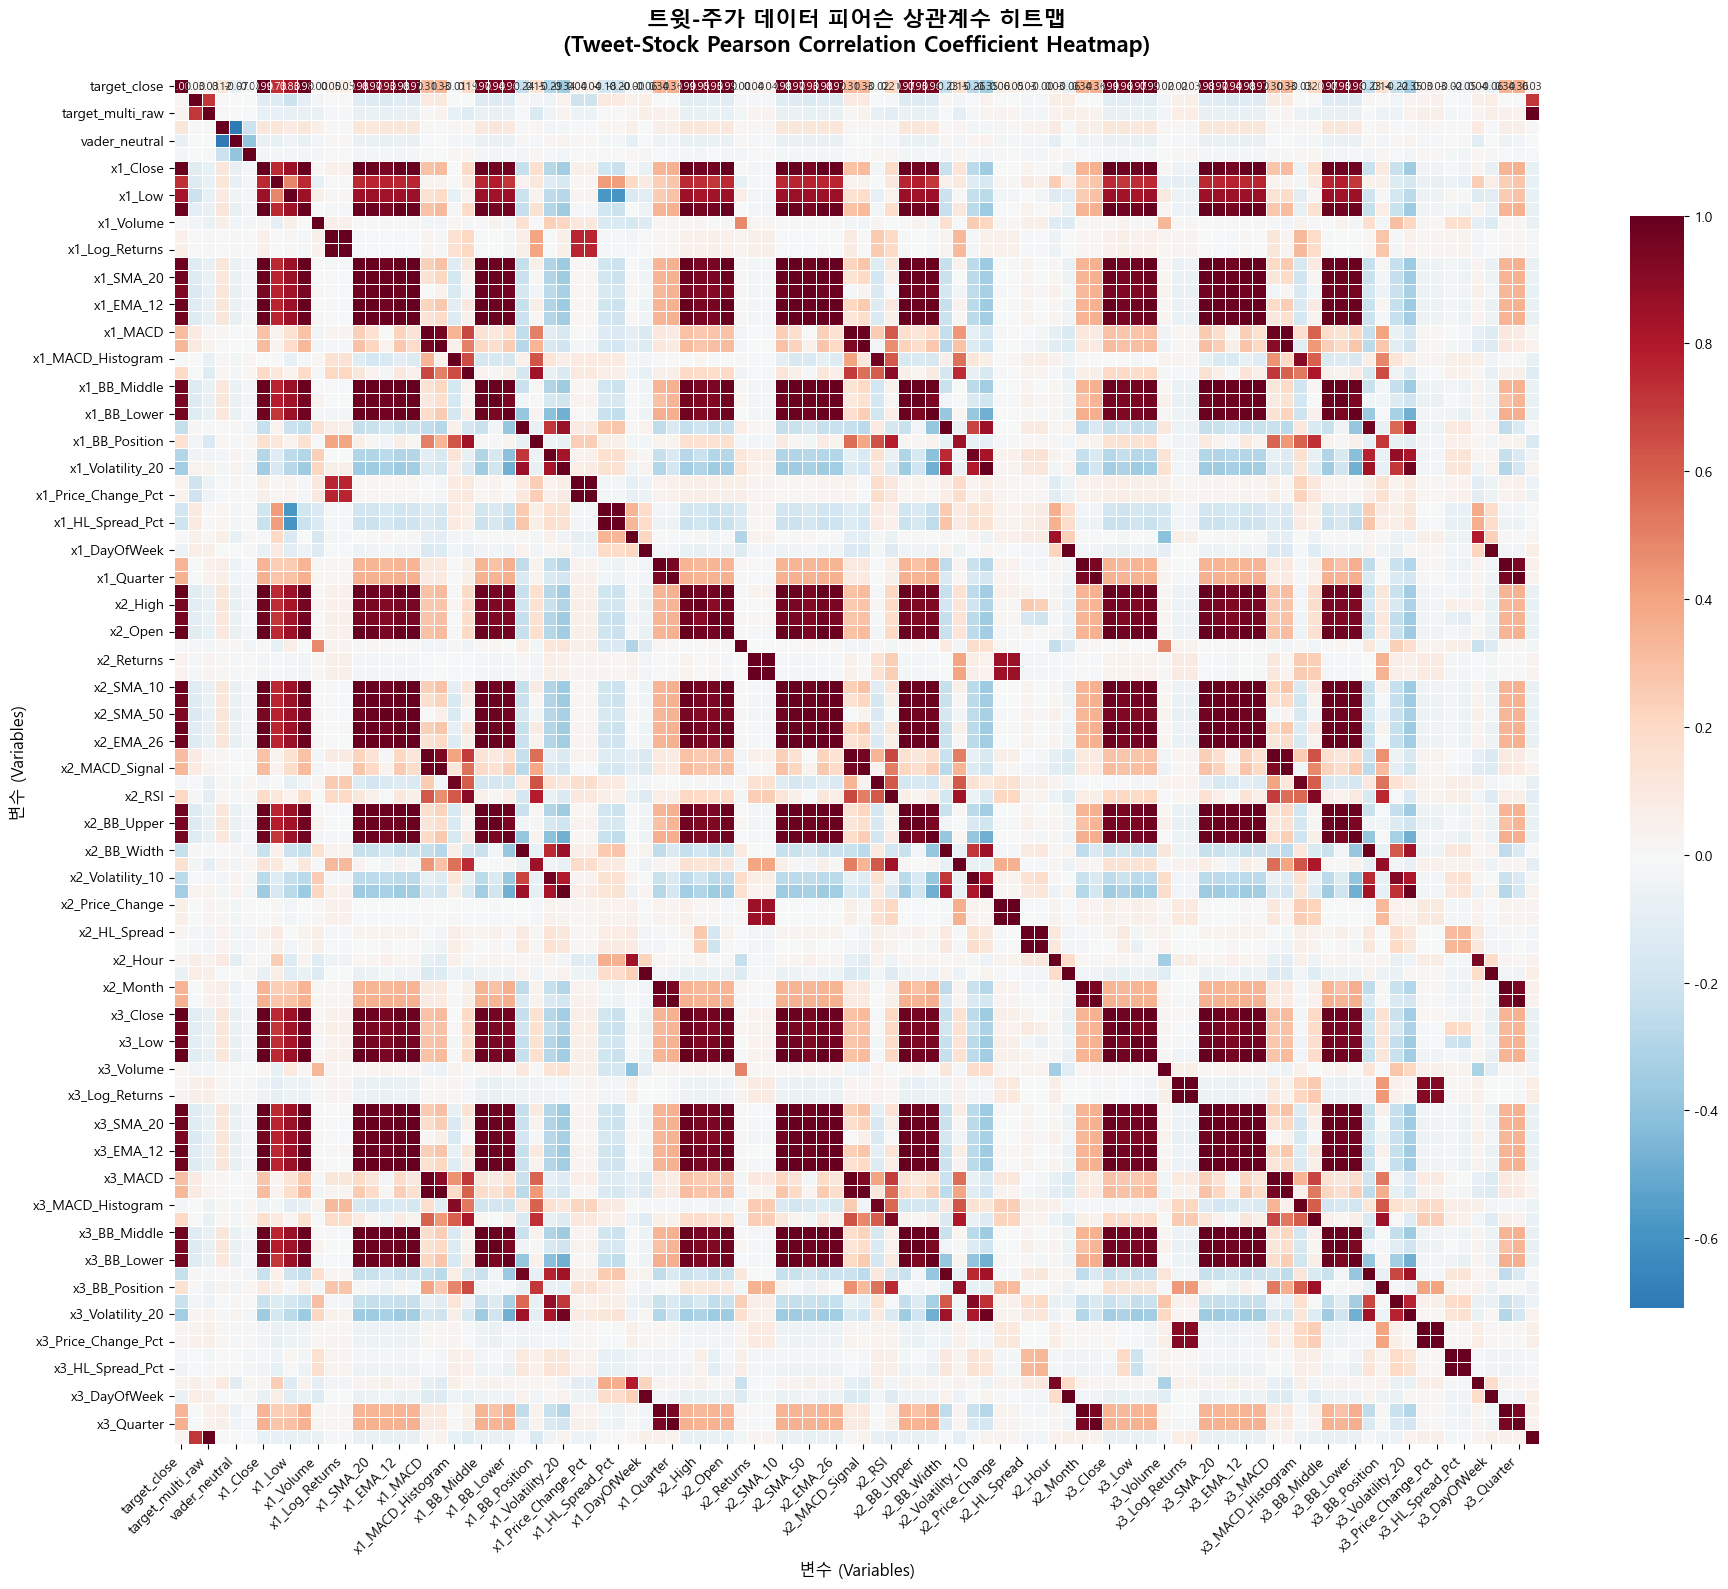


=== 타겟 변수(target_multi)와의 상관계수 (절댓값 기준 내림차순) ===
target_multi_raw     1.000000
target_multi         1.000000
target_return_pct    0.719646
x1_BB_Position       0.143783
x1_RSI               0.117912
x2_RSI               0.106329
x2_BB_Position       0.096431
x1_High              0.086271
x1_SMA_50            0.084812
x2_SMA_50            0.084438
x3_SMA_50            0.083828
x2_High              0.079947
x1_Low               0.079501
x1_MACD_Histogram    0.077353
x2_Open              0.075636
x1_Close             0.075201
x2_EMA_26            0.073983
x3_Log_Returns       0.073945
x1_EMA_26            0.073905
x3_Returns           0.073788
Name: target_multi, dtype: float64

=== 높은 상관관계 변수 쌍 (|상관계수| >= 0.7) ===
총 776개 쌍 발견
           Variable_1      Variable_2  Correlation
38   target_multi_raw    target_multi     1.000000
751         x3_SMA_20    x3_BB_Middle     1.000000
697        x2_Quarter      x3_Quarter     1.000000
565         x2_SMA_20    x2_BB_Middle     1.000000
212       

In [8]:
# =============================================================================
# 트윗-주가 데이터 피어슨 상관계수(Pearson Correlation Coefficient) 기반 히트맵 시각화
# =============================================================================

# 필요한 라이브러리 임포트
import pandas as pd  # 데이터 조작 및 분석용
import numpy as np  # 수치 계산용
import matplotlib.pyplot as plt  # 기본 플롯 생성용
import seaborn as sns  # 고급 통계 시각화용 (히트맵에 특화)

# 이전 셀에서 생성된 트윗-주가 병합 CSV 파일 불러오기
df = pd.read_csv("../data/tweet_stock_classification.csv")  # 트윗-주가 병합 데이터 로드

# 수치형 컬럼만 자동으로 선별 (상관계수는 수치형 데이터에만 적용 가능)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()  # int, float 타입 컬럼들만 추출

# 분석에 불필요한 ID 컬럼 제거 (ID는 식별용이므로 상관관계 분석에 부적절)
if 'tweet_id' in numeric_cols:  # tweet_id 컬럼이 존재하는지 확인
    numeric_cols.remove('tweet_id')  # 존재하면 제거 리스트에서 삭제

# 데이터 기본 정보 출력
print(f"분석할 수치형 변수 개수: {len(numeric_cols)}")  # 상관계수 분석에 사용할 변수 개수
print(f"데이터 크기: {df.shape}")  # 전체 데이터 크기 (행, 열)

# 피어슨 상관계수 매트릭스 계산
correlation_matrix = df[numeric_cols].corr()  # pandas의 corr() 함수로 모든 변수 간 상관계수 계산

# 히트맵 시각화를 위한 플롯 크기 설정
plt.figure(figsize=(20, 16))  # 매우 큰 캔버스 생성 (변수가 많을 때 가독성 확보)

# 한국어 폰트 설정 (제목과 레이블을 한국어로 표시하기 위함)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 기본 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호(-) 깨짐 방지

# seaborn을 이용한 히트맵 생성 (상관계수 시각화에 최적화된 함수)
sns.heatmap(correlation_matrix,  # 상관계수 매트릭스 데이터
            annot=True,          # 각 셀에 상관계수 수치 표시
            cmap='RdBu_r',       # 색상 팔레트: 빨강(음의 상관)-흰색(0)-파랑(양의 상관)
            center=0,            # 0을 색상 중심으로 설정 (중립적 색상 배치)
            square=True,         # 각 셀을 정사각형으로 만들어 균등한 비율 유지
            linewidths=0.5,      # 셀 간 경계선 두께 설정 (구분 명확화)
            cbar_kws={"shrink": .8},  # 컬러바(범례) 크기를 80%로 축소
            fmt='.2f',           # 상관계수를 소수점 둘째 자리까지 표시
            annot_kws={'size': 8})  # 셀 내 텍스트 크기 설정

# 플롯 제목 및 축 레이블 설정
plt.title('트윗-주가 데이터 피어슨 상관계수 히트맵\n(Tweet-Stock Pearson Correlation Coefficient Heatmap)',  # 이중 제목
          fontsize=16, fontweight='bold', pad=20)  # 폰트 크기, 굵기, 여백 설정
plt.xlabel('변수 (Variables)', fontsize=12)  # x축 레이블
plt.ylabel('변수 (Variables)', fontsize=12)  # y축 레이블

# 축 레이블 회전 및 정렬 (변수명이 길 때 가독성 향상)
plt.xticks(rotation=45, ha='right')  # x축 레이블을 45도 회전, 오른쪽 정렬
plt.yticks(rotation=0)  # y축 레이블은 수평 유지

# 레이아웃 자동 조정 (제목, 레이블이 겹치지 않도록)
plt.tight_layout()  # 플롯 요소들이 캔버스에 최적으로 배치되도록 조정
plt.show()  # 히트맵 출력

# =============================================================================
# 트윗 데이터 상관관계 분석 섹션
# =============================================================================

# 타겟 변수와 다른 모든 변수들의 상관관계 분석
target_corr = correlation_matrix['target_multi'].abs().sort_values(ascending=False)  # target_multi와의 상관계수 절댓값으로 정렬
print("\n=== 타겟 변수(target_multi)와의 상관계수 (절댓값 기준 내림차순) ===")
print(target_corr.head(20))  # 상위 20개 변수의 상관계수 출력

# 높은 상관관계를 가진 변수 쌍 탐지 함수 정의
def find_high_correlations(corr_matrix, threshold=0.7):
    """
    상관계수 매트릭스에서 임계값 이상의 높은 상관관계를 가진 변수 쌍을 찾는 함수
    Args:
        corr_matrix: 상관계수 매트릭스
        threshold: 임계값 (기본 0.7, 즉 70% 이상 상관관계)
    Returns:
        높은 상관관계 변수 쌍들의 DataFrame
    """
    high_corr_pairs = []  # 높은 상관관계 쌍들을 저장할 리스트
    
    # 상관계수 매트릭스의 상삼각형 부분만 순회 (중복 제거)
    for i in range(len(corr_matrix.columns)):  # 첫 번째 변수 인덱스
        for j in range(i+1, len(corr_matrix.columns)):  # 두 번째 변수 인덱스 (i+1부터 시작하여 중복 방지)
            corr_value = abs(corr_matrix.iloc[i, j])  # 상관계수의 절댓값
            if corr_value >= threshold:  # 임계값 이상인 경우
                high_corr_pairs.append({  # 딕셔너리 형태로 저장
                    'Variable_1': corr_matrix.columns[i],  # 첫 번째 변수명
                    'Variable_2': corr_matrix.columns[j],  # 두 번째 변수명
                    'Correlation': corr_matrix.iloc[i, j]  # 실제 상관계수 값 (음수 포함)
                })
    
    # DataFrame으로 변환 후 절댓값 기준으로 내림차순 정렬
    return pd.DataFrame(high_corr_pairs).sort_values('Correlation', key=abs, ascending=False)

# 높은 상관관계 변수 쌍 탐지 실행
high_corr_df = find_high_correlations(correlation_matrix, threshold=0.7)  # 0.7 이상 상관관계 탐지
print(f"\n=== 높은 상관관계 변수 쌍 (|상관계수| >= 0.7) ===")
print(f"총 {len(high_corr_df)}개 쌍 발견")  # 발견된 쌍의 개수
if len(high_corr_df) > 0:  # 높은 상관관계 쌍이 존재하는 경우
    print(high_corr_df.head(15))  # 상위 15개 쌍 출력

# VADER 감정 점수와 타겟 변수의 상관관계 별도 분석
vader_cols = [col for col in df.columns if 'vader' in col.lower()]  # 'vader'가 포함된 컬럼명 추출
if vader_cols:  # VADER 관련 컬럼이 존재하는 경우
    print(f"\n=== VADER 감정 점수와 타겟의 상관관계 ===")
    for col in vader_cols:  # 각 VADER 컬럼에 대해
        corr_val = correlation_matrix.loc['target_multi', col]  # 타겟과의 상관계수 추출
        print(f"{col}: {corr_val:.4f}")  # 소수점 넷째 자리까지 출력

# 상관계수 매트릭스의 전반적인 통계 정보
print(f"\n=== 상관계수 매트릭스 기본 정보 ===")
print(f"변수 개수: {correlation_matrix.shape[0]}")  # 매트릭스 크기 (변수 개수)
# 대각선 제외한 최대 상관계수 (자기 자신과의 상관계수 1.0 제외)
print(f"최대 상관계수: {correlation_matrix.values[correlation_matrix.values < 1].max():.4f}")
print(f"최소 상관계수: {correlation_matrix.values.min():.4f}")  # 최소 상관계수
# 대각선 제외한 평균 절댓값 상관계수 (전체적인 상관관계 강도 파악)
print(f"평균 절댓값 상관계수: {np.abs(correlation_matrix.values[correlation_matrix.values < 1]).mean():.4f}")


In [9]:
# =============================================================================
# 트윗 기반 LSTM 주가 방향 예측 모델 (딥러닝 시계열 분류)
# =============================================================================

# 필요한 라이브러리 임포트
import pandas as pd  # 데이터 조작용
import numpy as np  # 수치 계산용
import torch  # PyTorch 딥러닝 프레임워크
from torch import nn  # 신경망 모듈들
from torch.utils.data import DataLoader, TensorDataset  # 데이터 로더 및 텐서 데이터셋
from sklearn.model_selection import train_test_split  # 훈련/테스트 데이터 분리
from sklearn.preprocessing import StandardScaler  # 데이터 정규화
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # 평가 지표

# 1. 트윗-주가 데이터 불러오기
df = pd.read_csv("../data/tweet_stock_classification.csv", parse_dates=["tweet_time"])  # CSV 파일 로드, tweet_time을 날짜 타입으로 파싱

# 2. Feature 및 Label 준비
# 시계열 특성(x로 시작)과 감정 특성(vader_로 시작)만 선별
feature_cols = [col for col in df.columns if col.startswith("x") or col.startswith("vader_")]  # x1_Open, x2_High, vader_positive 등
X = df[feature_cols].fillna(0)  # 결측값을 0으로 채움 (주가 데이터에는 결측값이 거의 없음)
y = df["target_multi"]  # 타겟 변수 (0: 하락, 1: 보합, 2: 상승)

print(f"트윗 데이터 크기: {df.shape}")
print(f"사용할 특성 수: {len(feature_cols)}")
print(f"타겟 분포:\n{y.value_counts().sort_index()}")

# 3. 시계열 데이터 3-step 시퀀스 생성 (LSTM 입력 형태로 변환)
X_seq = []  # 시퀀스 데이터를 담을 리스트
for i in range(len(X)):  # 각 샘플(트윗)에 대해
    # 과거 3시점의 주가 데이터를 시간 순서대로 배열
    X_seq.append([
        X.iloc[i][[col for col in X.columns if col.startswith("x1_")]].values,  # 가장 오래된 시점 (t-2)
        X.iloc[i][[col for col in X.columns if col.startswith("x2_")]].values,  # 중간 시점 (t-1)  
        X.iloc[i][[col for col in X.columns if col.startswith("x3_")]].values   # 가장 최근 시점 (t)
    ])
X_seq = np.array(X_seq)  # 리스트를 numpy 배열로 변환 -> shape: (samples, time_steps, features)

# 4. VADER 감정 피처를 시계열 데이터에 추가
vader_feats = X[[c for c in X.columns if c.startswith("vader_")]].values  # VADER 감정 점수들만 추출
# VADER 점수를 각 시점마다 복사하여 시계열 형태로 변환 (트윗 감정은 모든 시점에서 동일)
vader_feats = np.repeat(vader_feats[:, np.newaxis, :], 3, axis=1)  # shape: (samples, 3, vader_features)
# 주가 시계열 데이터와 감정 데이터를 결합
X_seq = np.concatenate([X_seq, vader_feats], axis=-1)  # 마지막 차원(특성 차원)에서 결합

print(f"시계열 데이터 형태: {X_seq.shape}")  # (샘플수, 시간스텝, 특성수)

# 5. 데이터 정규화 (LSTM 학습 안정성을 위해 필수)
n_samples, time_steps, n_features = X_seq.shape  # 데이터 차원 정보 추출
X_reshaped = X_seq.reshape(-1, n_features)  # 2D로 변환하여 StandardScaler 적용 가능하게 함
scaler = StandardScaler()  # 평균 0, 표준편차 1로 정규화하는 스케일러
X_scaled = scaler.fit_transform(X_reshaped)  # 정규화 적용 (fit: 통계량 계산, transform: 변환)
X_seq = X_scaled.reshape(n_samples, time_steps, n_features)  # 다시 3D 시계열 형태로 복원

# 6. PyTorch Tensor로 변환 (GPU 연산 및 자동 미분을 위해)
X_tensor = torch.tensor(X_seq, dtype=torch.float32)  # 입력 데이터를 float32 텐서로 변환
y_tensor = torch.tensor(y.values, dtype=torch.long)  # 라벨을 long 타입 텐서로 변환 (분류용)

# 7. 훈련/테스트 데이터 분리
# shuffle=False: 시계열 데이터의 시간 순서 보존 (과거 데이터로 훈련, 미래 데이터로 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, shuffle=False)
# DataLoader: 미니배치 학습을 위한 데이터 로더 생성
train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)  # 훈련용: 셔플 ON
test_dl = DataLoader(TensorDataset(X_test, y_test), batch_size=32)  # 테스트용: 셔플 OFF

print(f"훈련 데이터: {X_train.shape}, 테스트 데이터: {X_test.shape}")

# 8. 트윗 기반 LSTM 분류 모델 클래스 정의
class TweetLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=3):
        """
        트윗 기반 LSTM 분류 모델
        Args:
            input_dim: 입력 특성 차원 수 (주가 + VADER 감정 점수)
            hidden_dim: LSTM 은닉층 크기 (기본 64)
            output_dim: 출력 클래스 수 (3: 하락/보합/상승)
        """
        super().__init__()  # 부모 클래스 초기화
        # LSTM 레이어: 시계열 패턴을 학습하는 순환신경망
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)  # batch_first=True: (batch, seq, feature) 순서
        # 드롭아웃: 과적합 방지
        self.dropout = nn.Dropout(0.3)  # 30% 뉴런을 랜덤하게 비활성화
        # 완전연결층: LSTM 출력을 분류 결과로 변환
        self.fc = nn.Linear(hidden_dim, output_dim)  # hidden_dim -> 3개 클래스

    def forward(self, x):
        """
        순전파 함수: 입력 데이터가 모델을 통과하는 과정
        Args:
            x: 입력 시계열 데이터 (batch_size, time_steps, features)
        Returns:
            분류 예측 결과 (batch_size, output_dim)
        """
        # LSTM 통과: output과 (hidden_state, cell_state) 반환
        _, (hn, _) = self.lstm(x)  # output은 사용하지 않음, 마지막 hidden state만 사용
        # 드롭아웃 적용 (훈련 시에만 활성화)
        hn_dropout = self.dropout(hn[-1])  # 마지막 LSTM 레이어의 마지막 시점 hidden state에 드롭아웃 적용
        # 마지막 시점의 hidden state를 완전연결층에 입력
        return self.fc(hn_dropout)  # 분류 결과 반환

# 9. 학습 환경 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU 사용 가능하면 GPU, 아니면 CPU
print(f"사용 디바이스: {device}")

model = TweetLSTMClassifier(input_dim=n_features).to(device)  # 모델 생성 후 디바이스로 이동
loss_fn = nn.CrossEntropyLoss()  # 다중분류용 손실함수 (소프트맥스 + 음의 로그 우도)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam 최적화기 (학습률 0.001)

# 모델 파라미터 수 출력
total_params = sum(p.numel() for p in model.parameters())
print(f"모델 총 파라미터 수: {total_params:,}")

# 10. 트윗 기반 모델 학습 루프
print(f"\n=== 트윗 기반 LSTM 모델 학습 시작 ===")
for epoch in range(50):  # 50 에포크 학습
    model.train()  # 모델을 훈련 모드로 설정 (드롭아웃, 배치정규화 활성화)
    total_loss = 0  # 에포크별 총 손실 초기화
    
    # 미니배치별 학습
    for xb, yb in train_dl:  # 훈련 데이터 로더에서 미니배치 가져오기
        xb, yb = xb.to(device), yb.to(device)  # 데이터를 GPU/CPU로 이동
        pred = model(xb)  # 순전파: 예측 결과 계산
        loss = loss_fn(pred, yb)  # 손실 계산 (예측값 vs 실제값)
        
        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()  # 이전 그래디언트 초기화 (PyTorch는 그래디언트 누적)
        loss.backward()  # 역전파: 그래디언트 계산
        optimizer.step()  # 가중치 업데이트
        
        total_loss += loss.item()  # 배치 손실을 총 손실에 누적
    
    # 에포크별 평균 손실 출력 (매 10 에포크마다)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/50 | Loss: {total_loss:.4f}")  # 소수점 넷째 자리까지 출력

print("트위터 기반 LSTM 학습 완료!")


트윗 데이터 크기: (5517, 102)
사용할 특성 수: 96
타겟 분포:
target_multi
0     816
1    3605
2    1096
Name: count, dtype: int64
시계열 데이터 형태: (5517, 3, 34)
훈련 데이터: torch.Size([4413, 3, 34]), 테스트 데이터: torch.Size([1104, 3, 34])
사용 디바이스: cpu
모델 총 파라미터 수: 25,795

=== 트윗 기반 LSTM 모델 학습 시작 ===
Epoch 10/50 | Loss: 61.0585
Epoch 20/50 | Loss: 37.7197
Epoch 30/50 | Loss: 24.2113
Epoch 40/50 | Loss: 16.1171
Epoch 50/50 | Loss: 11.8437
트위터 기반 LSTM 학습 완료!


In [10]:
# 11. 평가
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

print("\n Accuracy:", accuracy_score(all_labels, all_preds))
print("\n Classification Report:\n", classification_report(all_labels, all_preds))


 Accuracy: 0.6757246376811594

 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.78      0.82      0.80       791
           2       0.39      0.57      0.46       175

    accuracy                           0.68      1104
   macro avg       0.39      0.46      0.42      1104
weighted avg       0.62      0.68      0.65      1104



# 9. LightGBM 코드 (News 버전)

### Q. Light GBM 을 왜 News 만 해두었는가?

### A.
- Light GBM의 사용의도는 LSTM + MLP  모델이 얼마나 잘 나올까 하는 비교용도임
- 그러나 Light GBM은 시계열 용도의 모델이 아니고, Confusion matrix를 보았을때 값이 중립으로 심하게 편향됨
- 최종적으로 News Data만 적용함.

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
import lightgbm as lgb

# 1. 데이터 불러오기
df = pd.read_csv("../data/news_stock_classification.csv", parse_dates=["news_time"])

# 2. Feature 및 Label 준비
feature_cols = [col for col in df.columns if col.startswith("x") or col.startswith("finbert_")]
X = df[feature_cols].fillna(0)
y = df["target_multi"]

# 3. 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train/Test 분리 (LSTM 방식 그대로)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# 5. LightGBM 모델 및 GridSearchCV 세팅
lgb_clf = lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300],
    'max_depth': [3, 5]
}

# f1_macro로 평가
grid = GridSearchCV(
    estimator=lgb_clf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,           
    verbose=1,
    n_jobs=1
)

# 6. 학습
grid.fit(X_train, y_train)   

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21520
[LightGBM] [Info] Number of data points in the train set: 6867, number of used features: 96
[LightGBM] [Info] Start training from score -1.823269
[LightGBM] [Info] Start training from score -0.364171
[LightGBM] [Info] Start training from score -1.939813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

GridSearchCV(cv=3,
             estimator=LGBMClassifier(num_class=3, objective='multiclass',
                                      random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5], 'n_estimators': [100, 300]},
             scoring='f1_macro', verbose=1)

In [12]:
# 7. 평가
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print(" Best Params:", grid.best_params_)
print(" Accuracy:", accuracy_score(y_test, y_pred))
print(" Macro F1-score:", f1_score(y_test, y_pred, average="macro"))
print("\n Classification Report:\n", classification_report(y_test, y_pred)) 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
 Best Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
 Accuracy: 0.7169481654047758
 Macro F1-score: 0.2968467606472327

 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       246
           1       0.72      1.00      0.84      1224
           2       0.70      0.03      0.05       247

    accuracy                           0.72      1717
   macro avg       0.47      0.34      0.30      1717
weighted avg       0.61      0.72      0.60      1717



# 10. RandomForest (News Data)

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score

# 1. 데이터 로드
df = pd.read_csv("../data/news_stock_classification.csv", parse_dates=["news_time"])

# 2. Feature 및 Label 추출
feature_cols = [col for col in df.columns if col.startswith("x") or col.startswith("finbert_")]
X = df[feature_cols].fillna(0)
y = df["target_multi"]

# 시점 정의 (x1_ ~ x3_)
timesteps = [1, 2, 3]
step_feature_dims = []

# 시점별 컬럼 파악 및 시계열 구성
for t in timesteps:
    cols = [col for col in X.columns if col.startswith(f"x{t}_")]
    step_feature_dims.append(cols)

print("각 시점별 feature 개수:", [len(c) for c in step_feature_dims])

X_seq = []
for i in range(len(X)):
    timestep_data = []
    for cols in step_feature_dims:
        if cols:
            timestep_data.append(X.iloc[i][cols].values)
        else:
            timestep_data.append(np.zeros(len(cols)))
    X_seq.append(timestep_data)

X_seq = np.array(X_seq, dtype=float)  # (샘플, 3, features)
print("\n시퀀스 shape:", X_seq.shape)

# FinBERT 특성 추가
finbert_feats = X[[c for c in X.columns if c.startswith("finbert_")]].values  # (샘플, dim)
finbert_feats = np.repeat(finbert_feats[:, np.newaxis, :], 3, axis=1)        # (샘플, 3, dim)
X_seq = np.concatenate([X_seq, finbert_feats], axis=-1)                      # (샘플, 3, feature+finbert)

# 정규화
n_samples, time_steps, n_features = X_seq.shape
scaler = StandardScaler()
X_seq_reshaped = X_seq.reshape(-1, n_features)
X_scaled = scaler.fit_transform(X_seq_reshaped).reshape(n_samples, time_steps, n_features)

# 평탄화
X_flat = X_scaled.reshape(n_samples, -1)

# 시간 순으로 80% 학습, 20% 테스트
split_idx = int(len(X_flat) * 0.8)
X_train, X_test = X_flat[:split_idx], X_flat[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Random Forest 학습
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    random_state=42,
    n_jobs=1,
    class_weight='balanced'
)
print("\n=== 모델 학습 시작 ===")
model.fit(X_train, y_train)
print("학습 완료!")

# 예측 및 평가
y_pred = model.predict(X_test)

print("\n[평가 결과]")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Macro F1-score: {f1_score(y_test, y_pred, average='macro'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


각 시점별 feature 개수: [31, 31, 31]

시퀀스 shape: (8584, 3, 31)

=== 모델 학습 시작 ===
학습 완료!

[평가 결과]
Accuracy: 0.6750
Macro F1-score: 0.4288

Classification Report:
              precision    recall  f1-score   support

           0     0.2890    0.4593    0.3548       246
           1     0.8149    0.8415    0.8280      1224
           2     0.2581    0.0648    0.1036       247

    accuracy                         0.6750      1717
   macro avg     0.4540    0.4552    0.4288      1717
weighted avg     0.6594    0.6750    0.6560      1717



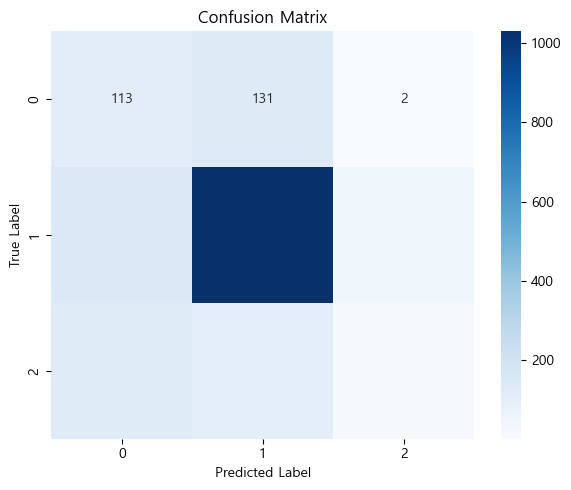

In [14]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 11. RandomForest (Tweets Data)

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt

# 1. 트위터 데이터 불러오기
df_tweet = pd.read_csv("../data/tweet_stock_classification.csv", parse_dates=["tweet_time"])

# 2. Feature 및 Label 준비 (LSTM Tweet 버전과 동일)
feature_cols_tweet = [col for col in df_tweet.columns if col.startswith("x") or col.startswith("vader_")]
X_tweet = df_tweet[feature_cols_tweet].fillna(0)
y_tweet = df_tweet["target_multi"]

print(f"Random Forest (Tweet) 데이터 크기: {df_tweet.shape}")
print(f"사용할 특성 수: {len(feature_cols_tweet)}")
print(f"타겟 분포:\n{y_tweet.value_counts().sort_index()}")

# 3. 정규화 (LSTM Tweet 버전과 동일)
scaler_tweet = StandardScaler()
X_tweet_scaled = scaler_tweet.fit_transform(X_tweet)

# 4. Train/Test 분리 (LSTM Tweet 버전과 동일한 방식)
X_train_tweet, X_test_tweet, y_train_tweet, y_test_tweet = train_test_split(X_tweet_scaled, y_tweet, test_size=0.2, shuffle=False)

print(f"훈련 데이터: {X_train_tweet.shape}, 테스트 데이터: {X_test_tweet.shape}")

# 5. Random Forest 분류 모델 생성 (Tweet 버전)
rf_model_tweet = RandomForestClassifier(
    n_estimators=300,        # 트리 개수
    max_depth=5,             # 최대 깊이
    random_state=42,         # 재현성을 위한 시드
    n_jobs=1,               # 모든 CPU 코어 사용
    class_weight='balanced'  # 클래스 불균형 처리
)

# 6. 모델 학습
print("\n=== Random Forest (Tweet 버전) 모델 학습 시작 ===")
rf_model_tweet.fit(X_train_tweet, y_train_tweet)
print("Random Forest (Tweet 버전) 학습 완료!")

# 7. 예측
y_pred_tweet = rf_model_tweet.predict(X_test_tweet)

# 8. 성능 평가 (LSTM Tweet 버전과 동일한 지표)
print("\n=== Random Forest (Tweet 버전) Model Performance ===")
print(f"Accuracy: {accuracy_score(y_test_tweet, y_pred_tweet):.4f}")
print(f"Macro F1-score: {f1_score(y_test_tweet, y_pred_tweet, average='macro'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_tweet, y_pred_tweet))


Random Forest (Tweet) 데이터 크기: (5517, 102)
사용할 특성 수: 96
타겟 분포:
target_multi
0     816
1    3605
2    1096
Name: count, dtype: int64
훈련 데이터: (4413, 96), 테스트 데이터: (1104, 96)

=== Random Forest (Tweet 버전) 모델 학습 시작 ===
Random Forest (Tweet 버전) 학습 완료!

=== Random Forest (Tweet 버전) Model Performance ===
Accuracy: 0.6938
Macro F1-score: 0.2731

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.71      0.97      0.82       791
           2       0.00      0.00      0.00       175

    accuracy                           0.69      1104
   macro avg       0.24      0.32      0.27      1104
weighted avg       0.51      0.69      0.59      1104



c:\Users\jhh33\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jhh33\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jhh33\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# (추가 실험) 피쳐 줄이기

### Q. 피쳐 줄이는 실험을 한 이유는?
### A. 피쳐를 줄이면 정확도와 평가가 잘 나오는지 확인하기 위해서 줄여본 것임

### Q. 줄여보니까 어떤 결과가 나왔는가?
### A.
- Accuracy가 더욱 편향되게 나오는 좋지 않은 결과가 나옴
- 결론적으로 피쳐는 줄이지 않는 것으로 결정

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# 1. 데이터 불러오기
df = pd.read_csv("../data/news_stock_classification.csv", parse_dates=["news_time"])

# 2. Feature 및 Label 준비
allowed_features = ["Open", "High", "Low", "Close", "Volume"]
feature_cols = [
    col for col in df.columns
    if (
        any(col.startswith(f"x{i}_") and any(f in col for f in allowed_features) for i in range(1, 4))
        or col.startswith("finbert_")
    )
]
X = df[feature_cols].fillna(0)
y = df["target_multi"]

# 3. 시계열 데이터 3-step 시퀀스 생성 (LSTM 입력 형태로 변환)
X_seq = []
for i in range(len(X)):
    X_seq.append([
        X.iloc[i][[col for col in X.columns if col.startswith("x1_")]].values,
        X.iloc[i][[col for col in X.columns if col.startswith("x2_")]].values,
        X.iloc[i][[col for col in X.columns if col.startswith("x3_")]].values
    ])
X_seq = np.array(X_seq)

# 4. FinBERT 감정 피처를 시계열 데이터에 추가
finbert_feats = X[[c for c in X.columns if c.startswith("finbert_")]].values
finbert_feats = np.repeat(finbert_feats[:, np.newaxis, :], 3, axis=1)
X_seq = np.concatenate([X_seq, finbert_feats], axis=-1)

# 5. 데이터 정규화
n_samples, time_steps, n_features = X_seq.shape
X_reshaped = X_seq.reshape(-1, n_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_seq = X_scaled.reshape(n_samples, time_steps, n_features)

# 6. Tensor로 변환
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

# 7. Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, shuffle=False)
train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_dl = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

# 8. LSTM 모델 정의
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

# 9. 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(input_dim=n_features).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 10. 학습 루프
for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

In [ ]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

print("\n Accuracy:", accuracy_score(all_labels, all_preds))
print("\n Classification Report:\n", classification_report(all_labels, all_preds))


 Accuracy: 0.623179965055329

 Classification Report:
               precision    recall  f1-score   support

           0       0.11      0.08      0.09       246
           1       0.71      0.84      0.77      1224
           2       0.21      0.06      0.10       247

    accuracy                           0.62      1717
   macro avg       0.34      0.33      0.32      1717
weighted avg       0.55      0.62      0.58      1717

